In [1]:
#INSTALLING DEPENDENCIES
!pip install torch==1.12.1
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 33.8 MB/s eta 0:00:00


In [2]:
#IMPORT LIBRARIES
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics import Accuracy
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
#DATA LOADER:
horizontal_flip_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5)])
batch_size=10000
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=horizontal_flip_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=horizontal_flip_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#UNPICKLING FILES INTO DICTIONARIES:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
dict1 = unpickle(file='./data/cifar-10-batches-py/data_batch_1')
dict2 = unpickle(file='./data/cifar-10-batches-py/data_batch_2')
dict3 = unpickle(file='./data/cifar-10-batches-py/data_batch_3')
dict4 = unpickle(file='./data/cifar-10-batches-py/data_batch_4')
dict5 = unpickle(file='./data/cifar-10-batches-py/data_batch_5')
dict_test = unpickle(file='./data/cifar-10-batches-py/test_batch')

#LOADING TRAIN AND TEST DATA
train_x1 = torch.tensor(dict1[b'data'])
train_y1 = torch.tensor(dict1[b'labels'])
train_x2 = torch.tensor(dict2[b'data'])
train_y2 = torch.tensor(dict2[b'labels'])
train_x3 = torch.tensor(dict3[b'data'])
train_y3 = torch.tensor(dict3[b'labels'])
train_x4 = torch.tensor(dict4[b'data'])
train_y4 = torch.tensor(dict4[b'labels'])
train_x5 = torch.tensor(dict5[b'data'])
train_y5 = torch.tensor(dict5[b'labels'])
test_x = torch.tensor(dict_test[b'data'])
test_y = torch.tensor(dict_test[b'labels'])

train_x = torch.cat((train_x1, train_x2, train_x3, train_x4, train_x5), dim=0)
train_y = torch.cat((train_y1, train_y2, train_y3, train_y4, train_y5), dim=0)
train_x = torch.reshape(train_x, (50000, 3, 32, 32))/255
test_x = torch.reshape(test_x, (10000, 3, 32, 32))/255

train_y_framed = torch.nn.functional.one_hot(train_y.clone().detach(), num_classes=10)
train_y_framed = torch.tensor(train_y_framed, dtype=torch.float)
test_y_framed = torch.nn.functional.one_hot(test_y.clone().detach(), num_classes=10)
test_y_framed = torch.tensor(test_y_framed, dtype=torch.float)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


<ipython-input-3-923f3ca44ac2>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_framed = torch.tensor(train_y_framed, dtype=torch.float)
<ipython-input-3-923f3ca44ac2>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y_framed = torch.tensor(test_y_framed, dtype=torch.float)


In [4]:
#DEFINING MODEL:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.con1 = torch.nn.Conv2d(3,32,(3,3),stride=(1,1), padding=(1,1), padding_mode='zeros')
        self.con2 = torch.nn.Conv2d(32,64,(5,5),stride=(1,1), padding=(1,1), padding_mode='zeros')
        self.con3 = torch.nn.Conv2d(64,64,(3,3),stride=(1,1), padding=(1,1), padding_mode='zeros')
        self.pool = torch.nn.MaxPool2d((2,2), stride=(2,2), padding=0)
        self.f1 = torch.nn.Linear(64*7*7, 64)
        self.f2 = torch.nn.Linear(64, 10)
        self.soft_max = torch.nn.LogSoftmax(dim=1)
        self.rel = torch.nn.functional.relu

    def forward(self, x):
        x = self.con1(x)
        x = self.rel(x)
        x = self.pool(x)
        x = self.con2(x)
        x = self.rel(x)
        x = self.pool(x)
        x = self.con3(x)
        x = self.rel(x)
        x = torch.reshape(x, (-1, 64*7*7))
        x = self.f1(x)
        x = self.rel(x)
        x = self.f2(x)
        predict = self.soft_max(x)
        return predict

#PARAMETERS:
epochs = 20
batch = 32
n_batches = 1562

In [12]:
#RUNNING THE MODEL ON TRAINING AND TESTING:
mymodel = Model().to('cuda:0')
# criterion = nn.CrossEntropyLoss()
kl_criterion = torch.nn.KLDivLoss(reduction="batchmean", log_target=True)
optimizer = optim.Adam(mymodel.parameters(), lr=0.001)
val_loss = torch.empty(epochs)
train_loss = torch.empty(epochs)
valb = 32
metric = Accuracy(task="multiclass", num_classes=10).to('cuda:0')
acc_t = np.zeros(epochs)
acc_v = np.zeros(epochs)
for epoch in range(epochs):
  rloss = 0
  acc = 0
  count = 0
  vloss = 0
  for b in range(n_batches):
  # for b in range(10):
    xbatch = train_x[(b)*batch:(b+1)*(batch)].to('cuda:0')
    ybatch = train_y_framed[(b)*batch:(b+1)*(batch)].to('cuda:0')
    predict = mymodel.forward(xbatch)
    loss = kl_criterion(predict,ybatch)
    optimizer.zero_grad()
    loss.backward()
    rloss+=loss.item()
    optimizer.step()
  predict_val = mymodel.forward(test_x[:2000].to('cuda:0'))
  loss2 = kl_criterion(predict_val, test_y_framed[:2000].to('cuda:0')).item()
  print(f"Training Loss after epoch {epoch+1}: {rloss}")
  train_loss[epoch] = rloss
  val_loss[epoch] = loss2
  predict_val_v = mymodel.forward(test_x[:2000].to('cuda:0'))
  predict_val_t = mymodel.forward(train_x[:2000].to('cuda:0'))
  pred_labels_v = torch.argmax(predict_val_v, dim=1)
  pred_labels_t = torch.argmax(predict_val_t, dim=1)
  acc_t[epoch]= metric(pred_labels_t, train_y[:2000].to('cuda:0'))
  acc_v[epoch]=metric(pred_labels_v, test_y[:2000].to('cuda:0'))
  print(f'TRAIN_ACC: {acc_t[epoch]}')
  print(f'VAL ACC: {acc_v[epoch]}')
  ## Validation loss 
  print(f"Validation Loss after epoch {epoch+1}: {loss2}")
  # p1 = torch.argmax(predic,dim=1)
  # p2 = torch.argmax(test_y_framed[:500], dim=1)
  # count = torch.sum(p2)
  # val_accs[epoch] = torch.sum(torch.where(p1==p2,1,0))/count
  # print(f'Validation acc after epoch {epoch+1}: {val_accs[epoch]}')
print(acc_t)
print(acc_v)


Training Loss after epoch 1: 46027.51787567139
TRAIN_ACC: 0.5899999737739563
VAL ACC: 0.5770000219345093
Validation Loss after epoch 1: 29.355833053588867
Training Loss after epoch 2: 45800.275550842285
TRAIN_ACC: 0.6639999747276306
VAL ACC: 0.6650000214576721
Validation Loss after epoch 2: 29.278217315673828
Training Loss after epoch 3: 45709.10815620422
TRAIN_ACC: 0.7059999704360962
VAL ACC: 0.6970000267028809
Validation Loss after epoch 3: 29.2510929107666
Training Loss after epoch 4: 45651.54692077637
TRAIN_ACC: 0.7129999995231628
VAL ACC: 0.6934999823570251
Validation Loss after epoch 4: 29.246156692504883
Training Loss after epoch 5: 45614.695764541626
TRAIN_ACC: 0.7390000224113464
VAL ACC: 0.6965000033378601
Validation Loss after epoch 5: 29.245447158813477
Training Loss after epoch 6: 45585.08208656311
TRAIN_ACC: 0.7490000128746033
VAL ACC: 0.6855000257492065
Validation Loss after epoch 6: 29.25461196899414
Training Loss after epoch 7: 45559.211446762085
TRAIN_ACC: 0.7699999809

In [13]:
#CALCULATING FINAL VALIDATION ACCURACY AND CLASSWISE ACCURACIES:
metric = Accuracy(task="multiclass", num_classes=10).to('cuda:0')
acc_metric = MulticlassAccuracy(num_classes=10, average=None).to('cuda:0')
# finalpred = mymodel.forward(test_x[:1000])
pred_labels = torch.argmax(predict_val_v, dim=1)
classaccs = acc_metric(pred_labels, test_y[:2000].to('cuda:0'))
accfinal = metric(pred_labels, test_y[:2000].to('cuda:0'))
print(accfinal)
print(classaccs)
# class_acc[0]=classaccs

tensor(0.6545, device='cuda:0')
tensor([0.5816, 0.7323, 0.3897, 0.5678, 0.6465, 0.5622, 0.8102, 0.6373, 0.7880,
        0.7882], device='cuda:0')


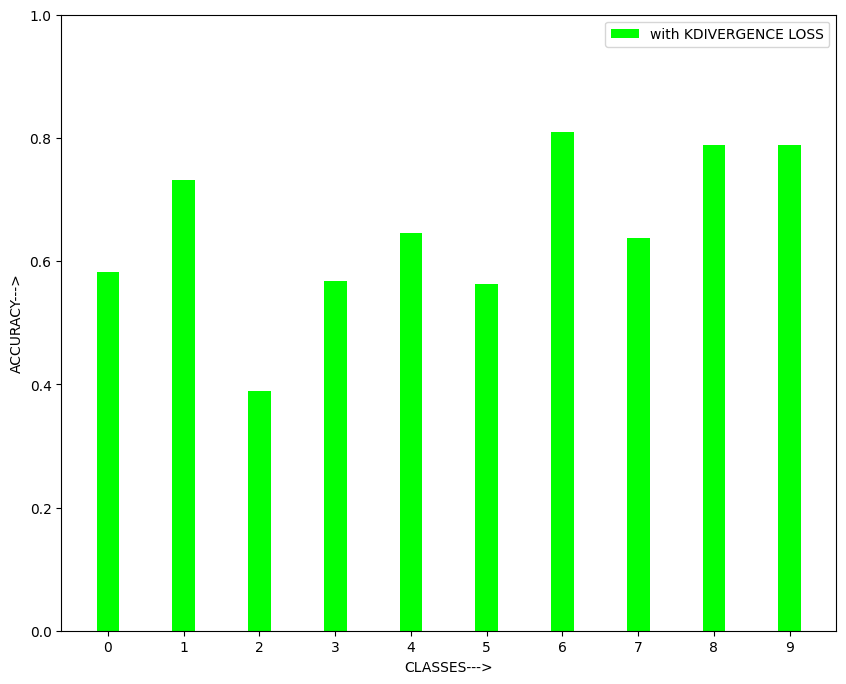

In [14]:
#CLASSWISE ACCURACY BAR-GRAPH
plt.figure(figsize=(10,8))
plt.xlabel('CLASSES--->')
plt.ylabel('ACCURACY--->')
plt.xticks(np.arange(0,10))
plt.ylim(0,1)
plt.bar(np.arange(0,10),classaccs.to('cpu'),color='lime',label='with KDIVERGENCE LOSS',width=0.3)
plt.legend()
plt.show()

In [15]:
#PRINTING THE LOSSES:
print(train_loss)
print(val_loss)
train_loss = train_loss/499.84
val_loss = val_loss/20
print(train_loss)
print(val_loss)
tloss = train_loss.detach().numpy()
vloss = val_loss.detach().numpy()

tensor([46027.5195, 45800.2773, 45709.1094, 45651.5469, 45614.6953, 45585.0820,
        45559.2109, 45538.0469, 45519.4531, 45501.9688, 45485.8945, 45473.2734,
        45462.0508, 45451.1875, 45439.8945, 45428.1250, 45423.3242, 45416.9570,
        45405.8086, 45393.5977])
tensor([29.3558, 29.2782, 29.2511, 29.2462, 29.2454, 29.2546, 29.2542, 29.2511,
        29.2510, 29.2642, 29.2720, 29.2773, 29.2955, 29.3091, 29.3203, 29.3182,
        29.3159, 29.3164, 29.3176, 29.3399])
tensor([92.0845, 91.6299, 91.4475, 91.3323, 91.2586, 91.1993, 91.1476, 91.1052,
        91.0680, 91.0331, 91.0009, 90.9757, 90.9532, 90.9315, 90.9089, 90.8853,
        90.8757, 90.8630, 90.8407, 90.8163])
tensor([1.4678, 1.4639, 1.4626, 1.4623, 1.4623, 1.4627, 1.4627, 1.4626, 1.4626,
        1.4632, 1.4636, 1.4639, 1.4648, 1.4655, 1.4660, 1.4659, 1.4658, 1.4658,
        1.4659, 1.4670])


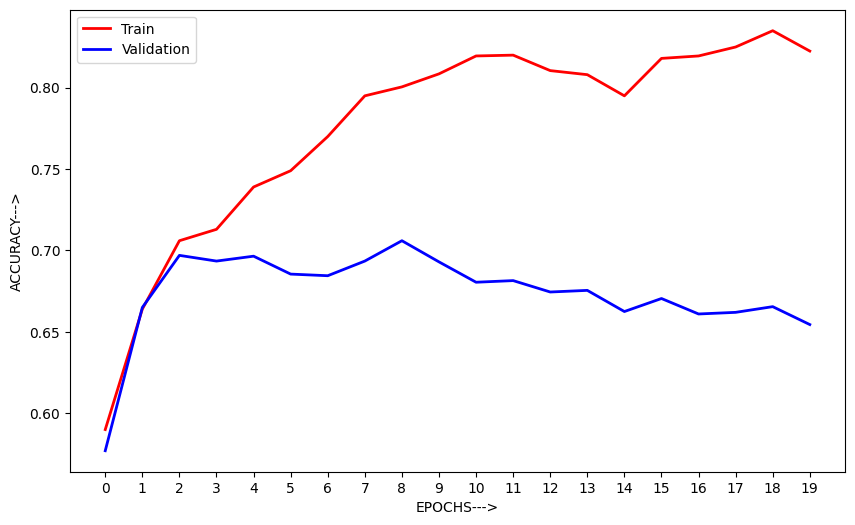

In [16]:
#CODE TO PLOT VALIDATION ACCURACY:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('ACCURACY--->')
epoch_arr = np.arange(0,20)
epoch_ticks = np.arange(0,22)
plt.xticks(epoch_ticks)
# plt.ylim(90,93)
plt.plot(epoch_arr, acc_t, 'r', label='Train', linewidth=2)
plt.plot(epoch_arr, acc_v, 'b', label='Validation', linewidth=2)
plt.legend()
plt.show()

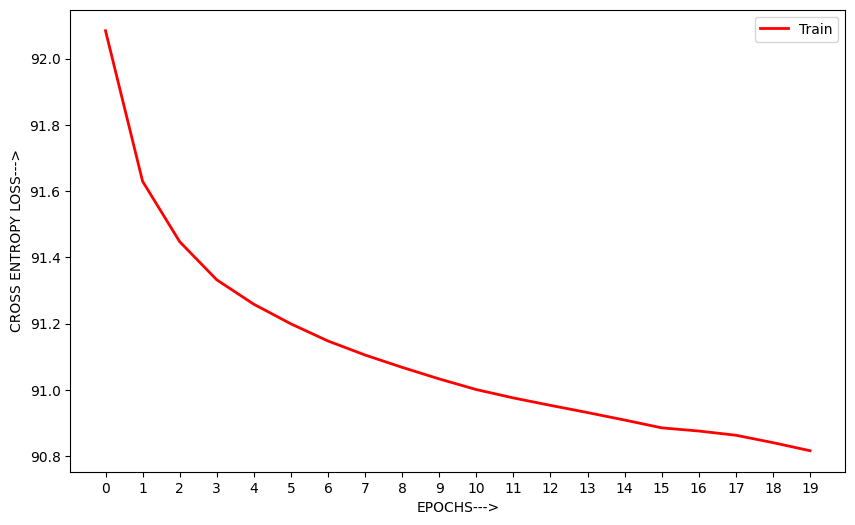

In [17]:
#CODE TO PLOT TRAINING AND VALIDATION LOSSES:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('CROSS ENTROPY LOSS--->')
epoch_arr = np.arange(0,20)
epoch_ticks = np.arange(0,22)
plt.xticks(epoch_ticks)
# plt.ylim(90,93)
plt.plot(epoch_arr, train_loss, 'r', label='Train', linewidth=2)
# plt.plot(epoch_arr, val_loss, 'b', label='Validation', linewidth=2)
plt.legend()
plt.show()

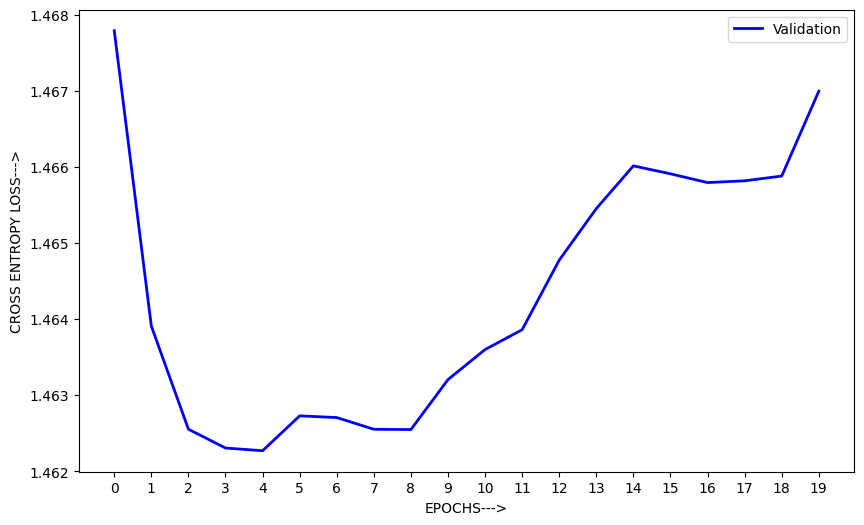

In [18]:
#CODE TO PLOT TRAINING AND VALIDATION LOSSES:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('CROSS ENTROPY LOSS--->')
epoch_arr = np.arange(0,20)
epoch_ticks = np.arange(0,22)
plt.xticks(epoch_ticks)
# plt.ylim(90,93)
# plt.plot(epoch_arr, train_loss, 'r', label='Train', linewidth=2)
plt.plot(epoch_arr, val_loss, 'b', label='Validation', linewidth=2)
plt.legend()
plt.show()